In [1]:
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import os
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [3]:
data_dir = 'data/gaussian_filtered_images/gaussian_filtered_images'

dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [4]:
# Assuming transforms and dataset setup is done as before
data_dir = 'data/gaussian_filtered_images/gaussian_filtered_images'
dataset = datasets.ImageFolder(root=data_dir, transform=transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
]))

# Creating a DataLoader for visualization
data_loader = DataLoader(dataset, batch_size=4, shuffle=True)

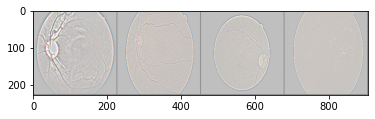

Labels:  No_DR Mild No_DR Moderate


In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(data_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
classes = dataset.classes
print('Labels: ', ' '.join(f'{classes[labels[j]]}' for j in range(len(labels))))

In [6]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [7]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [8]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
for param in vgg16.parameters():
    param.requires_grad = False

In [10]:
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, 5)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

In [12]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (Optimizing only the classifier parameters, as the feature parameters are frozen)
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)

In [13]:
criterion = criterion.to(device)

In [22]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    return epoch_loss, epoch_acc.item()

In [23]:
def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)

    return epoch_loss, epoch_acc.item()

Epoch 1/10
----------
Train Loss: 0.7002 Acc: 0.7494
Validation Loss: 0.6711 Acc: 0.7503
Epoch 2/10
----------
Train Loss: 0.6937 Acc: 0.7433
Validation Loss: 0.6931 Acc: 0.7367
Epoch 3/10
----------
Train Loss: 0.6928 Acc: 0.7375
Validation Loss: 0.6712 Acc: 0.7531
Epoch 4/10
----------
Train Loss: 0.6800 Acc: 0.7511
Validation Loss: 0.6660 Acc: 0.7572
Epoch 5/10
----------
Train Loss: 0.6762 Acc: 0.7480
Validation Loss: 0.6688 Acc: 0.7572
Epoch 6/10
----------
Train Loss: 0.6932 Acc: 0.7501
Validation Loss: 0.6690 Acc: 0.7572
Epoch 7/10
----------
Train Loss: 0.6876 Acc: 0.7477
Validation Loss: 0.6910 Acc: 0.7203
Epoch 8/10
----------
Train Loss: 0.6965 Acc: 0.7518
Validation Loss: 0.6802 Acc: 0.7558
Epoch 9/10
----------
Train Loss: 0.6961 Acc: 0.7511
Validation Loss: 0.6734 Acc: 0.7503
Epoch 10/10
----------
Train Loss: 0.6935 Acc: 0.7477
Validation Loss: 0.6765 Acc: 0.7558


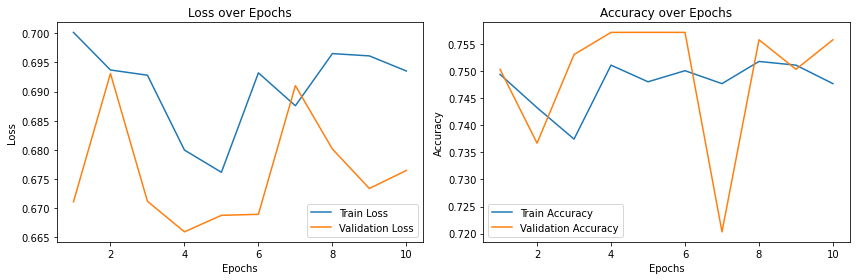

In [24]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
train_acc = []
val_acc = []

num_epochs = 10  # Adjust as needed

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    train_loss, train_accuracy = train_model(vgg16, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate_model(vgg16, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_acc.append(train_accuracy)
    val_acc.append(val_accuracy)

    print(f'Train Loss: {train_loss:.4f} Acc: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}')

# Plotting
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_acc, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
